In [1]:
###### dataset metadata
#!pip install seaborn
from pipelines import train_mini, train, test
from pipelines import ScriptDataset, transform_pipeline, test_transform_pipeline, minimal_preprocessing_pipeline
from blf_torch import BilateralFilter

from torch.utils.data import DataLoader
import torchvision.models as models
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn

from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch.multiprocessing as mp

from PIL import Image 

import random
import time
import math
import os
from IPython.display import clear_output

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
            classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

import gc # garbage collection
import pickle
import pandas as pd

loading image metadata... done


In [2]:
import csv

with open('train2.csv', mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)  # Reads the CSV into a list of dictionaries
    train = [{**row, 'label_num': int(row['label_num'])} for row in reader]  # Convert label_num to int

with open('val.csv', mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)  # Reads the CSV into a list of dictionaries
    val = [{**row, 'label_num': int(row['label_num'])} for row in reader]  # Convert label_num to int

In [3]:
# if __name__ == '__main__':
#     mp.set_start_method('spawn', force=True)

# available pipelines for RN50:
# minimal_preprocessing_pipeline
# transform_pipeline
# test_transform_pipeline

num_available_cores = len(os.sched_getaffinity(0))
print('CPU cores available:', num_available_cores)

script_dataset = ScriptDataset(train, transform=transform_pipeline, multiplier=50, max_size=None)
ds_len = len(script_dataset)
print('length of dataset after crop sampling:',ds_len)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    pin_memory_ind=True
else: pin_memory_ind = False

# data_loader = DataLoader(script_dataset, num_workers = num_available_cores,
#                          batch_size=48, shuffle=True, pin_memory=False)

data_loader = DataLoader(script_dataset, batch_size=50, shuffle=True, pin_memory=pin_memory_ind, num_workers = 2#num_available_cores
                        , prefetch_factor=num_available_cores * 3, persistent_workers=True)


script_dataset_noGeo = ScriptDataset(train, transform=test_transform_pipeline, multiplier=50, max_size=None)
data_loader_noGeo = DataLoader(script_dataset_noGeo, batch_size=50, shuffle=True, pin_memory=pin_memory_ind, num_workers = 2#num_available_cores
                        , prefetch_factor=num_available_cores * 3, persistent_workers=True)

script_dataset_noBLF_noGeo = ScriptDataset(train, transform=minimal_preprocessing_pipeline, multiplier=50, max_size=None)
data_loader_noBLF_noGeo = DataLoader(script_dataset_noBLF_noGeo, batch_size=50, shuffle=True, pin_memory=pin_memory_ind, num_workers = 2#num_available_cores
                        , prefetch_factor=num_available_cores * 3, persistent_workers=True)

sample_images, sample_labels = next(iter(data_loader))
batches =  math.ceil(len(script_dataset) /sample_labels.shape[0])
print("Image batch shape:", sample_images.shape)  # Expected: [batch_size, 3, 224, 224]
print("Label batch shape:", sample_labels.shape)  # Expected: [batch_size]
print("Number of batches:",batches)

CPU cores available: 36
length of dataset after crop sampling: 256000


/users/robl/.conda/envs/capstone2/lib/python3.13/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (98944020 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Image batch shape: torch.Size([50, 3, 500, 500])
Label batch shape: torch.Size([50])
Number of batches: 5120


/users/robl/.conda/envs/capstone2/lib/python3.13/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (98944020 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [5]:
num_classes = 12
in_y = 500
in_x = 500

model_rn50 = models.resnet50(weights="DEFAULT") #  weights='DEFAULT' and weights='IMAGENET1K_V1' are the same
model_rn50.fc = torch.nn.Linear(2048, num_classes)  # Adjust output layer for your number of classes
model_rn50.conv1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=2, padding=5, bias=False)


model_resnext = models.resnext101_64x4d(weights="DEFAULT") 
model_resnext.fc = torch.nn.Linear(2048, num_classes)  
model_resnext.conv1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=2, padding=5, bias=False)



model_efficientnet = models.efficientnet_b0(weights="DEFAULT") 
model_efficientnet.classifier[1] = torch.nn.Linear(1280, num_classes) 
model_efficientnet.features[0][0] = nn.Conv2d(
    in_channels=3, out_channels=32, kernel_size=(7, 7), stride=(2, 2), padding=3, bias=False
)


model_convnext = models.convnext_tiny(weights="DEFAULT") 
model_convnext.classifier[2] = torch.nn.Linear(768, num_classes)  
model_convnext.features[0][0] = nn.Conv2d(
    in_channels=3, out_channels=96, kernel_size=(8, 8), stride=(4, 4), padding=3, bias=False
)


model_convnext_noBLF_noGeo = models.convnext_tiny(weights="DEFAULT") 
model_convnext_noBLF_noGeo.classifier[2] = torch.nn.Linear(768, num_classes)  
model_convnext_noBLF_noGeo.features[0][0] = nn.Conv2d(
    in_channels=3, out_channels=96, kernel_size=(8, 8), stride=(4, 4), padding=3, bias=False
)




model_efficientnet_noGeo = models.efficientnet_b0(weights="DEFAULT") 
model_efficientnet_noGeo.classifier[1] = torch.nn.Linear(1280, num_classes) 
model_efficientnet_noGeo.features[0][0] = nn.Conv2d(
    in_channels=3, out_channels=32, kernel_size=(7, 7), stride=(2, 2), padding=3, bias=False
)

model_efficientnet_noBLF_noGeo = models.efficientnet_b0(weights="DEFAULT") 
model_efficientnet_noBLF_noGeo.classifier[1] = torch.nn.Linear(1280, num_classes) 
model_efficientnet_noBLF_noGeo.features[0][0] = nn.Conv2d(
    in_channels=3, out_channels=32, kernel_size=(7, 7), stride=(2, 2), padding=3, bias=False
)





In [6]:
model_dict = {
    "resnet50": model_rn50,
    "resnext101": model_resnext,
    "efficientnet_b0": model_efficientnet,
    "convnext_tiny": model_convnext,

    
    "efficientnet_b0_noBLF_noGeo": model_efficientnet_noBLF_noGeo,
    # "efficientnet_b0_noGeo": model_efficientnet_noGeo,
    "model_convnext_noBLF_noGeo": model_convnext_noBLF_noGeo
    # "quicktest":quicktest
}
loss_history = {}

In [ ]:
# filter_device = torch.device("cuda:0")   # For BilateralFilter

for model_name, model in model_dict.items():
    # script_dataset = ScriptDataset(train, transform=transform_pipeline, multiplier=50, max_size=None) # normal
    script_dataset = ScriptDataset(train, transform=minimal_preprocessing_pipeline, multiplier=50, max_size=None) # no Geo
    # script_dataset = ScriptDataset(train, transform=minimal_preprocessing_pipeline, multiplier=50, max_size=None) # no BLF, no Geo
    # sample_images, sample_labels = next(iter(data_loader))
    batches =  math.ceil(len(script_dataset) /sample_labels.shape[0])
    data_loader = DataLoader(script_dataset, batch_size=50, shuffle=True, pin_memory=pin_memory_ind, num_workers = num_available_cores
                        , prefetch_factor=num_available_cores * 3, persistent_workers=True)

    loss_history[model_name] = []
    loss_list = []
    
    batch_threshold = batches // 6
    
    early_stopping_patience = 100
    min_batches_before_stopping = batch_threshold * 3
    best_loss = float('inf')
    no_improvement_count = 0
    
    model.to(device)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)#, device_ids=[1, 2])
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scaler = torch.amp.GradScaler(device='cuda')
    # Move model to GPU if available
    
        
    
    
    start_time = 0
    
    
    # Training loop (simplified)
    for batch_idx, (images, labels) in enumerate(data_loader):
        if batch_idx == 0:
            start_time= time.time()
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type='cuda'):  # FP16 precision for faster matrix ops
            outputs = model(images)
            loss = criterion(outputs, labels)
    
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
        # Compute top-k accuracy 
        # k = 3
    
        # This test gruadually requires a more specific match to continue training
        if batch_idx >= 2 * batch_threshold:  
            k = 1  # 33% and beyond
        elif batch_idx >= batch_threshold:  
            k = 2  # Between 16% and 33%
        else:  
            k = 3  # First 16%
    
            
        # Get the indices of the top k predictions for each sample
        _, topk_preds = outputs.topk(k, dim=1, largest=True, sorted=True)
        # Check if the true labels are among the top k predictions
        correct_topk = topk_preds.eq(labels.view(-1, 1).expand_as(topk_preds))
        topk_accuracy = correct_topk.float().sum() / images.size(0)
        clear_output(wait=True)
        print(f"\n🚀 Training {model_name}...\n", end='')
        print(f"Batch {batch_idx} of {batches}, Loss: {loss.item():.4f}", end = '    ')
    
        # GPU Monitoring
        allocated = torch.cuda.memory_allocated(device) / 1024**2
        reserved = torch.cuda.memory_reserved(device) / 1024**2
        
        # print(f"GPU Memory Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB")
        elapsed_time = (time.time() - start_time) / 60
        time_needed = elapsed_time * (batches / (batch_idx+1))
        print(f"time: {elapsed_time:.2f} min,  remaining: {time_needed:.2f} min")
    
        
        loss_value = loss.detach().to(device).item()  # Ensure it's detached and on the correct device
        loss_history[model_name].append(loss_value)
        loss_list.append(loss_value)
        if batch_idx >= min_batches_before_stopping:  
            if loss_value < best_loss:
                best_loss = loss_value 
                no_improvement_count = 0  # Reset counter if loss improves
            else:
                no_improvement_count += 1  # Increment counter if no improvement
        
            # Stop if loss hasn't improved for `early_stopping_patience` consecutive checks
            if no_improvement_count >= early_stopping_patience:
                print(f"🛑 Early Stopping Triggered at Batch {batch_idx}")
                break
        # outputs = model(images)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # optimizer.step()
        # print("Loss:", loss.item())
    total_time = time.time() - start_time
    total_time_minutes = total_time / 60  # Convert seconds to minutes
    images_per_min = ds_len / total_time_minutes if total_time_minutes > 0 else 0
    
    print(f"✅ Training Completed | Total Time: {total_time:.2f}s ({total_time_minutes:.2f} min) | Images Per Minute: {images_per_min:.2f}")
    
    model_path = f"pickle/{model_name}.pkl"
    with open(model_path, "wb") as f:
        pickle.dump(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(), f)
    print(f"\n✅ {model_name} saved to {model_path}\n")   

    loss_filename = f"loss_{model_name}.csv"
    pd.DataFrame(loss_list, columns=["loss"]).to_csv(loss_filename, index=False)

    
    del model, optimizer, scaler
    torch.cuda.empty_cache()  # Free GPU memory
    gc.collect()  # Force Python garbage collection

Using 8 GPUs!


/users/robl/.conda/envs/capstone2/lib/python3.13/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96324336 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/users/robl/.conda/envs/capstone2/lib/python3.13/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (98944020 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/users/robl/.conda/envs/capstone2/lib/python3.13/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (98944020 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/users/robl/.conda/envs/capstone2/lib/python3.13/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (103744953 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/users/robl/.conda/envs/capstone2/lib/python3.13/site-packages/PIL/Image.py:3402: Decom

# Cross Val Predict - output tuning

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

oof_proba = np.zeros(len(y_train_array))
fold_thresholds = []

train_proba_positive = best_grid_model.predict_proba(X_train_scaled)[:, 1]

thresholds = np.linspace(0.1, 0.9, 17)
threshold_costs = []
for threshold in thresholds:
    # Apply threshold to get predicted labels
    train_pred = (train_proba_positive >= threshold).astype(int)
    
    # Compute custom cost
    cost = cost_score(y_train_array, train_pred)
    threshold_costs.append((threshold, cost))

optimal_threshold, optimal_cost = min(threshold_costs, key=lambda x: x[1])
print("Optimal threshold:", optimal_threshold)
print("Optimal unit cost (train):", optimal_cost / len(y_train_array))

In [ ]:
# Generate OOF predictions using cross_val_predict
oof_proba = cross_val_predict(
    best_grid_model,            # Best model from RandomizedSearchCV
    X_complete,      # Entire dataset
    y_complete,       # Target labels
    cv=5,                # Same CV strategy as RandomizedSearchCV
    method='predict_proba'     # Predict class labels
)

oof_proba_positive = oof_proba[:, 1]
oof_preds = (oof_proba_positive >= optimal_threshold).astype(int)

# Test ConvNext

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of pickled model names (assumes they've been saved as `{model_name}.pkl`)
model_names = ["resnet50", "resnext101", "efficientnet_b0", "convnext_tiny"]

# Dictionary to store results
results = []

# Loop through each model
for model_name in model_names:
    print(f"\n🚀 Evaluating {model_name}...\n")

    # Load the model
    model_path = f"{model_name}.pkl"
    if model_name == "resnet50":
        model = models.resnet50()
    elif model_name == "resnext101":
        model = models.resnext101_64x4d()
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0()
    elif model_name == "convnext_tiny":
        model = models.convnext_tiny()
    else:
        raise ValueError(f"Model {model_name} is not recognized!")

# Load model weights
with open(model_path, "rb") as f:
    model.load_state_dict(pickle.load(f))

    model.to(device)
    model.eval()

    # Prepare test dataset and DataLoader
    test_dataset = ScriptDataset(test[:10], transform=minimal_preprocessing_pipeline, multiplier=1)
    test_loader = DataLoader(test_dataset, batch_size=150, shuffle=False)

    # Initialize tracking variables
    correct_top1 = 0
    correct_top3 = 0
    total = 0
    all_preds = [] 
    all_labels = []

    ds_len = len(test_loader)
    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader, start=1):
            images, labels = images.to(device), labels.to(device)
            
            sum_probs = torch.zeros(images.size(0), len(test_dataset.classes), device=device)

            # Run multiple passes for ensemble-like voting
            num_runs = 15
            for _ in range(num_runs):
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                sum_probs += probs

            # Compute top-k predictions
            topk_probs, topk_preds = torch.topk(sum_probs, k=3, dim=1)
            top1_preds = topk_preds[:, 0]

            # Update accuracy calculations
            correct_top1 += (top1_preds == labels).sum().item()
            correct_top3 += (topk_preds == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)

            all_preds.extend(top1_preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())

            clear_output(wait=True)
            print(f"Processing batch {batch_idx}/{ds_len}... ({batch_idx/ds_len:.2%} complete)")

    # Compute final accuracy metrics
    top1_accuracy = (correct_top1 / total) * 100
    top3_accuracy = (correct_top3 / total) * 100
    total_time = time.time() - start_time
    total_time_minutes = total_time / 60
    images_per_min = ds_len / total_time_minutes if total_time_minutes > 0 else 0

    print(f"✅ {model_name} Evaluation Completed | Top-1 Accuracy: {top1_accuracy:.2f}% | Top-3 Accuracy: {top3_accuracy:.2f}%")
    
    # Store results
    results.append({"Model": model_name, "Top-1 Accuracy": top1_accuracy, "Top-3 Accuracy": top3_accuracy, "Total Time (min)": total_time_minutes})

    # Clean up GPU memory before loading the next model
    del model
    torch.cuda.empty_cache()

# Convert results to DataFrame and save
results_df = pd.DataFrame(results)
results_df.to_csv("model_evaluation_results.csv", index=False)

print("\n✅ All models evaluated! Results saved to `model_evaluation_results.csv`.\n")


🚀 Evaluating resnet50...


🚀 Evaluating resnext101...


🚀 Evaluating efficientnet_b0...


🚀 Evaluating convnext_tiny...



RuntimeError: Error(s) in loading state_dict for ConvNeXt:
	Missing key(s) in state_dict: "features.0.0.bias". 
	size mismatch for features.0.0.weight: copying a param with shape torch.Size([96, 3, 8, 8]) from checkpoint, the shape in current model is torch.Size([96, 3, 4, 4]).
	size mismatch for classifier.2.weight: copying a param with shape torch.Size([12, 768]) from checkpoint, the shape in current model is torch.Size([1000, 768]).
	size mismatch for classifier.2.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([1000]).

In [7]:
#metrics 
top1_accuracy = (correct_top1 / total) * 100
top3_accuracy = (correct_top3 / total) * 100

print(f"🔹 Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"🔹 Top-3 Accuracy: {top3_accuracy:.2f}%\n")

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")


print("Classification Report:") 
print(classification_report(all_labels, all_preds, digits=4))

🔹 Top-1 Accuracy: 53.00%
🔹 Top-3 Accuracy: 73.00%

Precision (macro): 0.5285
Recall (macro):    0.5001
F1-score (macro):  0.4957
Classification Report:
              precision    recall  f1-score   support

           0     0.6000    0.6667    0.6316         9
           1     0.5000    0.7500    0.6000        16
           2     0.8000    0.6667    0.7273         6
           3     0.0000    0.0000    0.0000         1
           4     1.0000    0.5000    0.6667         6
           5     0.1667    0.0714    0.1000        14
           6     0.8182    0.8182    0.8182        11
           7     0.2857    0.3333    0.3077         6
           8     0.4000    0.4444    0.4211         9
           9     0.2000    0.5000    0.2857         2
          10     0.5714    0.5000    0.5333        16
          11     1.0000    0.7500    0.8571         4

    accuracy                         0.5300       100
   macro avg     0.5285    0.5001    0.4957       100
weighted avg     0.5439    0.5300   

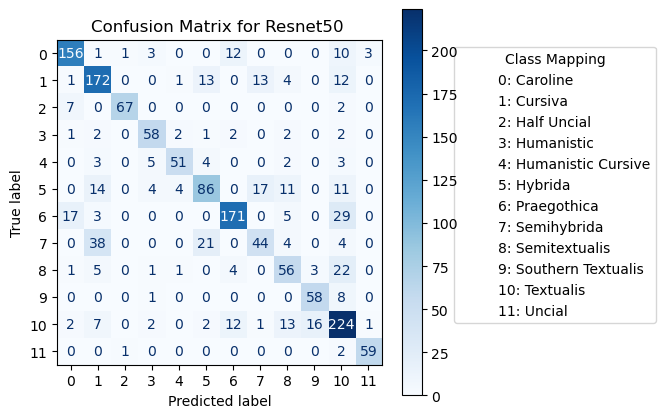

In [29]:
from load_clamm import convert_to_script
script_labels = [convert_to_script(c + 1) for c in range(12)]

conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)#, display_labels=script_labels)
disp.plot(cmap=plt.cm.Blues, values_format = 'd')
plt.title("Confusion Matrix for Resnet50 ")
#plt.xticks(rotation = 75)
legend_handles = [mpatches.Patch(color='none', label=f"{i}: {script_labels[i]}") for i in range(len(script_labels))]
plt.legend(handles=legend_handles, title="Class Mapping", loc='upper left', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()


